### **Painting Logs**

The main idea behind the following files is try to predict when a trace will end in error as soon as possible. For this purpose, it is important to define some considerations that will be the basis on which the work will be carried out: 
- The meaning of each trace (and each log) is unknown.
- ERROR label and trace size are the most important features to consider 
- A full study of the parameters of the models used will not be necessary for the time being. The development of the idea will be the priority. 

The complete idea consists of 3 steps:
- **Painting Logs**: Visualisation of the most important topic for each trace. The clustering algorithm that will be used is LDA (Latent Dirichlet Allocation) but it can be extrapolated to any other clustering algorithm. 
- **Heavy Topics**: An exploratory way of characterising topics based on their frequency in error traces. Later on, more sophisticated methods will be used (e.g. Word2Vec, PCA)
- **Realtime detect**: This is the final step where the previous ideas are implemented in "real time".

Note: The real purpose of this work is not to "create" some predictive method but to put into practice knowledge learned in class and to try to learn new machine learning techniques.

#### **First Step: Painting Logs.**

The hypothesis that led to the development of this idea is that "there are logs in early parts of the trace that warn that the trace will end in error". However, since the meaning of the trace is unkown, it is necessary to implement another technique to capture this hidden info. One approach may be to try to group data according to their similarity.  Thus, we will implement clustering algorithms, specifically LDA!

The information that we are intered in capturing is: What is the main topic associated to each log-trace? working with this info can be complicated and we may risk not understanding the full picture of the situation in a trace, and this is where Painting logs comes in. Painting logs is a practical (but not original, I know that) way of visualisation that allows to understand the behaviour of a trace with respect to its topics and can be extrapolated to any clustering algorithm

Let's stat by getting familiar with the data.

#### Data Overview
The dataset used comes from Paranal Observatory and is composed  of 2846 traces of which 74 are errors traces (2,6%) and 2772 non error traces (97,4%). Each of these traces contains a variable number of logs (size trace) and  is associated to a boolean error label (i.e. True or False). 

In [1]:
from functions import *
import pandas as pd
import numpy as np

ds= TplPionier(config=config.ds_medium)
print("Number of  ERROR-traces: ",ds.index['ERROR'].value_counts()[1] )
print("Number of  NON ERROR-traces: "   , ds.index['ERROR'].value_counts()[0] )
ds.index

Loaded file: Corpus\Pionier_medium_11052023_v1.pkl
Number of  ERROR-traces:  74
Number of  NON ERROR-traces:  2772


START                              END  \
0    2020-12-01 06:58:21.518000+00:00 2020-12-01 07:01:26.742000+00:00   
1    2020-12-01 07:01:24.696000+00:00 2020-12-01 07:01:26.742000+00:00   
2    2020-12-01 07:01:41.277000+00:00 2020-12-01 07:01:43.260000+00:00   
3    2020-12-01 07:02:46.781000+00:00 2020-12-01 07:02:48.675000+00:00   
4    2020-12-01 07:10:51.269000+00:00 2020-12-01 07:20:26.003000+00:00   
...                               ...                              ...   
2841 2021-01-01 19:11:33.498000+00:00 2021-01-01 19:11:58.376000+00:00   
2842 2021-01-01 19:11:58.394000+00:00 2021-01-01 19:12:33.041000+00:00   
2843 2021-01-01 23:42:24.783000+00:00 2021-01-01 23:42:29.354000+00:00   
2844 2021-01-01 23:42:29.369000+00:00 2021-01-01 23:44:39.640000+00:00   
2845 2021-01-01 23:44:39.640000+00:00 2021-01-01 23:44:43.135000+00:00   

      TIMEOUT   system   procname                   TPL_ID  ERROR  Aborted  \
0       False  PIONIER    bob_ins     PIONIER_gen_tec_scan   True    False   
1       False  PIONIER  bob_18920     PIONIER_gen_tec_scan   True    False   
2       False  PIONIER  bob_18920     PIONIER_gen_tec_scan  False    False   
3       False  PIONIER  bob_18920     PIONIER_gen_tec_scan  False    False   
4       False  PIONIER    bob_ins   PIONIER_obs_calibrator  False    False   
...       ...      ...        ...                      ...    ...      ...   
2841    False  PIONIER    bob_ins    PIONIER_gen_tec_setup  False    False   
2842    False  PIONIER    bob_ins  PIONIER_gen_tec_standby  False    False   
2843    False  PIONIER    bob_ins    PIONIER_gen_tec_setup  False    False   
2844    False  PIONIER    bob_ins  PIONIER_gen_tec_fluxopt  False    False   
2845    False  PIONIER    bob_ins  PIONIER_gen_tec_standby  False    False   

      estimated (s)  real (s)  diff (s)  SECONDS  
0                 5         2         3    185.0  
1                 5         2         3      2.0  
2                 5         2         3      1.0  
3                 5         2         3      1.0  
4               308       935       387    574.0  
...             ...       ...       ...      ...  
2841             30        25         5     24.0  
2842            100        35        25     34.0  
2843             30         5        25      4.0  
2844             -1        -1        -1    130.0  
2845            100         4        56      3.0  

[2846 rows x 12 columns]

For example, we have that the size of trace 6 is 101 logs and is associated to the Non-Error label (False)

In [2]:
idx=6 #idx trace
print("Trace size: ", ds.load_trace(idx).shape[0])
print("Error trace: ", ds.index['ERROR'][idx] )
ds.load_trace(idx).head()

Trace size:  101
Error trace:  False


@timestamp   system envname keywmask procname logtype  \
0 2020-12-01 07:24:22.441000+00:00  PIONIER    wpnr           bob_ins     LOG   
1 2020-12-01 07:24:22.441000+00:00  PIONIER    wpnr           bob_ins     LOG   
2 2020-12-01 07:24:22.664000+00:00  PIONIER    wpnr           bob_ins     LOG   
3 2020-12-01 07:24:22.664000+00:00  PIONIER    wpnr           bob_ins     LOG   
4 2020-12-01 07:24:22.664000+00:00  PIONIER    wpnr           bob_ins     LOG   

                                               event  
0     PIONIER_gen_cal_dark -- Dark calibration (y...  
1        Started at 2020-12-01T07:24:22 (underlined)  
2                               SEQ SHUT2 LIST = 'F'  
3                               SEQ SHUT1 LIST = 'F'  
4                                     SEQ DOIT = 'T'

As we saw in the example above, each trace have a column named "event" in which the logs are described. These events (logs) will be the raw material for training our LDA. However, it is important to establish some considerations:
- 1) Each events will be a token. 
- 2) The "cleaning function" is not made by us and cannot be changed
- 3) We do not consider data balancing techniques at this stage.

#### Colorization function:

In [3]:
colorise=dataset.TplPionierColor()
print(colorise.help())

Colorization class "TplPionierColor"
Inherits from: Paranal1, Numbers, Telescopes, VLTSW, BaseColor

Colorization is done in the following order:

Paranal1: Recommended for Paranal, version 1
    OBS.TARG.NAME "CD_44_3318" -> OBS.TARG.NAME {}
    OBS.PROG.ID "3c5A-24(X)" -> OBS.PROG.ID {}
    OBS.NAME "SCI_NXPup_2" -> OBS.NAME {}
Numbers: Transform numbers in tokens
    -10.54 -> {}
    9.1e-2.1 -> {}
Telescopes: Tokenize telescope related hardware
    wat1tcs -> {watXtcs}
    lat2trk -> {latXtrk}
VLTSW: VLTSW Tokenizers
    cmd321 -> {cmdXXX}  for commands
    bob_492 -> {bob_XXX} bob instances


In [5]:
n=6
trace= ds.load_trace(n, cols=['@timestamp','event'])
trace['colour']= trace['event'].apply(colorise.color)

pd.set_option('max_colwidth', 400)
print("TRACE {}".format(n))
trace[ ['event', 'colour']].head(10)

TRACE 6


event  \
0     PIONIER_gen_cal_dark -- Dark calibration (yellow)   
1           Started at 2020-12-01T07:24:22 (underlined)   
2                                  SEQ SHUT2 LIST = 'F'   
3                                  SEQ SHUT1 LIST = 'F'   
4                                        SEQ DOIT = 'T'   
5                           DPR TECH = 'INTERFEROMETRY'   
6                                  SEQ SHUT4 LIST = 'F'   
7                                     DPR TYPE = 'DARK'   
8                                    SEQ NSCANS = '100'   
9                                  SEQ SHUT3 LIST = 'F'   

                                              colour  
0  PIONIER_gen_cal_dark -- Dark calibration (yellow)  
1                         Started at {} (underlined)  
2                               SEQ SHUT2 LIST = 'F'  
3                               SEQ SHUT1 LIST = 'F'  
4                                     SEQ DOIT = 'T'  
5                        DPR TECH = 'INTERFEROMETRY'  
6                               SEQ SHUT4 LIST = 'F'  
7                                  DPR TYPE = 'DARK'  
8                                  SEQ NSCANS = '{}'  
9                               SEQ SHUT3 LIST = 'F'

### Corpus Building 🔒

In [6]:
from tqdm import tqdm

def corpus_creation(ds,colorise):

    serie=pd.Series()
    rows_1=[ [colorise.color(a) for a in ds.load_trace(i)["event"]] for i in tqdm(range(len(ds.index)), desc='Traces Progress')]
    rows_2 = [[x.strip() for x in sublist] for sublist in rows_1]
    rows_3=[ [x.replace(' ','_') for x in sublist] for sublist in rows_2]
    serie=serie.append(pd.Series(rows_3))
    corpus_df=pd.DataFrame(serie, columns=['tokens'])
    return corpus_df

#### Little reminder:

- If u wanna import a specific corpus, you need to give the specific name remembering the format: "{Instrument}\_{size_data}\_{date}\_{version}". 
- Otherwise, only by using the name of the instrument and size of the data, you cant import the last corpus created

For example

In [7]:
try:
    corpus_load=load_corpus( filename='Pionier_medium_11052023_v1.pkl') #Given the specific name
except:  
    corpus= corpus_creation(ds.index, colorise)
    save_corpus_to_pickle(corpus, 'Pionier', 'medium') 
    corpus_load=load_corpus( instrument='Pionier', size='medium') #Imported the last corpus created

Loaded file: Pionier_medium_11052023_v1.pkl


Using a nested list for format issues:

In [8]:
list_tokens_new=[]
for tok in corpus_load.tokens:
    str_tok=" ".join(tok)
    list_tokens_new.append(str_tok)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer( min_df = 1, max_df=0.5, encoding='utf-8', tokenizer=my_tokenizer)

features= tfidf.fit_transform(list_tokens_new)

print("Number of unique tokens: ",features.shape[1])
print("Number of traces: ",features.shape[0])

Number of unique tokens:  879
Number of traces:  2846


In [10]:
df_ds= pd.DataFrame( features.todense(), columns=tfidf.get_feature_names()  )
print(df_ds.shape)
df_ds.head()

(2846, 879)


##access_command_done  ##setup_command_failed.  ##status_command_failed  \
0                    0.0                 0.140245                      0.0   
1                    0.0                 0.198847                      0.0   
2                    0.0                 0.000000                      0.0   
3                    0.0                 0.000000                      0.0   
4                    0.0                 0.000000                      0.0   

   (obs.name:_dailyalignment_//_obs.id:_{})  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   (obs.name:_observationconf_//_obs.id:_{})  \
0                                   0.102089   
1                                   0.000000   
2                                   0.000000   
3                                   0.000000   
4                                   0.000000   

   -_error_performing_command_offsopd_(issprserr_to_wait_brcmd_ready_:_timeout_while_waiting_for_broadcast_command_(offsopd)_ready)._(red)  \
0                                                                                                                                      0.0   
1                                                                                                                                      0.0   
2                                                                                                                                      0.0   
3                                                                                                                                      0.0   
4                                                                                                                                      0.0   

   -_waiting_to_complete_cmd_status_on_ics.  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   ..._calibration{arg}pionier_cal.seq{arg}{}{arg}$revision:_{}_$"_tpl.nexp_{}_tpl.expno_{}_(blue)  \
0                                                                                              0.0   
1                                                                                              0.0   
2                                                                                              0.0   
3                                                                                              0.0   
4                                                                                              0.0   

   ..._calibrator{arg}pionier_obs.seq{arg}{}{arg}$revision:_{}_$"_tpl.nexp_{}_tpl.expno_{}_(blue)  \
0                                                                                             0.0   
1                                                                                             0.0   
2                                                                                             0.0   
3                                                                                             0.0   
4                                                                                             0.0   

   ..._det.fram.preproc_t_ocs.det.imgname_pionier_gen_ptc_(blue)  ...  \
0                                                            0.0  ...   
1                                                            0.0  ...   
2                                                            0.0  ...   
3                                                            0.0  ...   
4                                                            0.0  ...   

   {}_-_ic0fbidevdrvdiscretemotor.c:{}:_iobcy:_scale_factor_=_{}  \
0                                                            0.0   
1                              

### LDA

In [11]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA

t=5
ldia= LDiA( n_components= t, learning_method='batch')
ldia=ldia.fit(df_ds)
ldia.components_.shape

(5, 879)

In [12]:
pd.set_option('display.width', 40)

columns= ['topic{}'.format(i) for i in range(t)]
components= pd.DataFrame(ldia.components_.T, index=df_ds.columns, columns= columns)

components.round(2).head(10)

topic0  \
##access_command_done                                                                                                                      0.20   
##setup_command_failed.                                                                                                                    2.47   
##status_command_failed                                                                                                                    0.20   
(obs.name:_dailyalignment_//_obs.id:_{})                                                                                                   0.20   
(obs.name:_observationconf_//_obs.id:_{})                                                                                                  0.20   
-_error_performing_command_offsopd_(issprserr_to_wait_brcmd_ready_:_timeout_while_waiting_for_broadcast_command_(offsopd)_ready)._(red)    0.20   
-_waiting_to_complete_cmd_status_on_ics.                                                                                                   0.20   
..._calibration{arg}pionier_cal.seq{arg}{}{arg}$revision:_{}_$"_tpl.nexp_{}_tpl.expno_{}_(blue)                                           14.90   
..._calibrator{arg}pionier_obs.seq{arg}{}{arg}$revision:_{}_$"_tpl.nexp_{}_tpl.expno_{}_(blue)                                             0.21   
..._det.fram.preproc_t_ocs.det.imgname_pionier_gen_ptc_(blue)                                                                              0.22   

                                                                                                                                         topic1  \
##access_command_done                                                                                                                     14.80   
##setup_command_failed.                                                                                                                    0.20   
##status_command_failed                                                                                                                   10.36   
(obs.name:_dailyalignment_//_obs.id:_{})                                                                                                   0.23   
(obs.name:_observationconf_//_obs.id:_{})                                                                                                  0.20   
-_error_performing_command_offsopd_(issprserr_to_wait_brcmd_ready_:_timeout_while_waiting_for_broadcast_command_(offsopd)_ready)._(red)    0.20   
-_waiting_to_complete_cmd_status_on_ics.                                                                                                   0.20   
..._calibration{arg}pionier_cal.seq{arg}{}{arg}$revision:_{}_$"_tpl.nexp_{}_tpl.expno_{}_(blue)                                            0.20   
..._calibrator{arg}pionier_obs.seq{arg}{}{arg}$revision:_{}_$"_tpl.nexp_{}_tpl.expno_{}_(blue)                                             0.20   
..._det.fram.preproc_t_ocs.det.imgname_pionier_gen_ptc_(blue)                                                                              0.20   

                                                                                                                                         topic2  \
##access_command_done                                                                                                                      0.20   
##setup_command_failed.                                                                                                                    0.24   
##status_command_failed                                                                                                                    0.20   
(obs.name:_dailyalignment_//_obs.id:_{})                                                                                                   0.20   
(obs.name:_observationconf_//_obs.id:_{})                                                                                                  7.80   
-_error_performing_

In [13]:
#most important logs for the topic 0
components.topic2.sort_values(ascending=False)[:30]

last_reply_to_command_id_ok_received                                                                                                                   101.908973
waiting_(timeout_)_for_pending_replies_to_command_id_ok                                                                                                101.908973
waiting_(timeout_{})_for_pending_replies_to_command_offsopd_id_{cmdxxx}                                                                                 82.084810
last_reply_to_command_offsopd_id_{cmdxxx}_received                                                                                                      81.922863
moving_delay_of_beam_{}_to_{}_mm_...                                                                                                                    80.472768
send_command_offsopd_->_beam_{}_-_offset_{}_(blue)                                                                                                      80.410762
send_command_offsopd_{},{}_t

In [14]:
ldia_topic_vector= ldia.transform(df_ds)

columns= [ 'topic{}'.format(i) for i in range(ldia.n_components)]

ldia_topic_vector= pd.DataFrame( ldia_topic_vector, columns=columns)

print(ldia_topic_vector.shape)
ldia_topic_vector.round(2).head()

(2846, 5)


topic0  topic1  topic2  topic3  \
0    0.15    0.02    0.68    0.02   
1    0.42    0.04    0.04    0.04   
2    0.04    0.04    0.04    0.04   
3    0.04    0.04    0.04    0.04   
4    0.72    0.02    0.21    0.02   

   topic4  
0    0.13  
1    0.46  
2    0.85  
3    0.85  
4    0.02

### Optimal LDA

LDA_2 saved ...
LDA_3 saved ...
LDA_4 saved ...
LDA_5 saved ...
LDA_6 saved ...
LDA_7 saved ...
LDA_8 saved ...
LDA_9 saved ...
LDA_10 saved ...
LDA_11 saved ...
LDA_12 saved ...
LDA_13 saved ...
LDA_14 saved ...
LDA_15 saved ...
LDA_16 saved ...
LDA_17 saved ...
LDA_18 saved ...
LDA_19 saved ...
LDA_20 saved ...


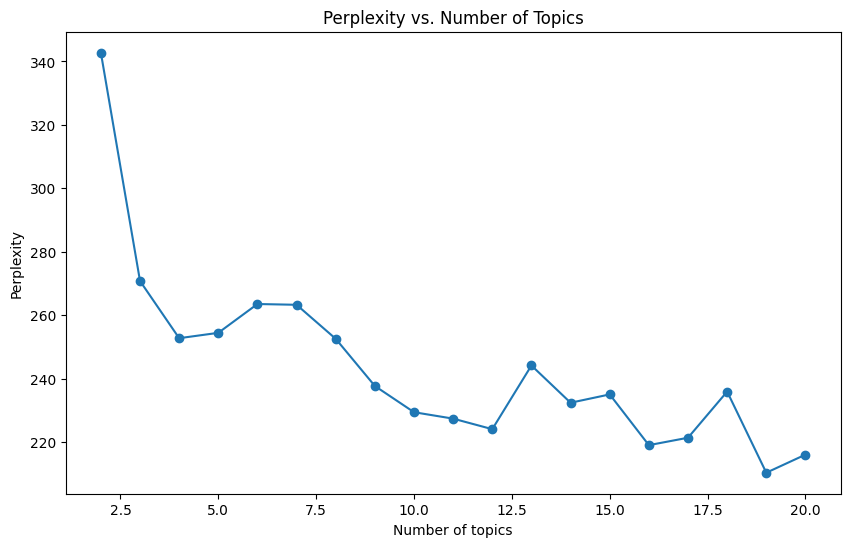

In [15]:
min_topics=2; max_topics=20
perplexities = []
for num_topics in range(min_topics, max_topics+1):
    lda_model = LDiA(n_components=num_topics, max_iter=10, random_state=42)
    lda_model.fit(df_ds)
    identifier= 'Pionier_medium_11052023_v1'
    model_name = f"LDA_{num_topics}_topics_{identifier}"

    model_path = os.path.join("LDA_models", f"{model_name}.pkl")
    with open(model_path, "wb") as model_file:
        pickle.dump(lda_model, model_file)
    print(f"LDA_{num_topics} saved ...")


    perplexity = lda_model.perplexity(df_ds)
    perplexities.append(perplexity)

# Crear el gráfico de perplejidad vs. número de tópicos
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(min_topics, max_topics+1), perplexities, marker='o')
ax.set_xlabel('Number of topics')
ax.set_ylabel('Perplexity')
ax.set_title('Perplexity vs. Number of Topics')

# Mostrar el gráfico
plt.show()

In [16]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(ldia, features, tfidf)

c:\Users\rlagos\anaconda3\envs\nlp2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  \
topic                               
0     -0.273285 -0.235004       1   
2     -0.105544  0.361846       2   
4      0.258883 -0.076007       3   
3      0.222058 -0.035618       4   
1     -0.102112 -0.015216       5   

       cluster       Freq  
topic                      
0            1  39.097724  
2            1  22.304098  
4            1  15.147320  
3            1  13.622949  
1            1   9.827909  , topic_info=                                Term  \
275  ins.lamp1.start_lamp_turned_on.   
577                   seq_doit_=_'f'   
171           calibration_skipped...   
609       seq_shut4_list_=_'f_f_f_t'   
605       seq_shut3_list_=_'f_f_t_f'   
..                               ...   
235               dpr_catg_=_'calib'   
237      dpr_tech_=_'interferometry'   
586                seq_nscans_=_'{}'   
585                 seq_nexpo_=_'{}'   
276  ins.lamp1.stop_lamp_turned_off.   

           Freq       Total Category  \
275  161.000000  161.000000  Default   
577   78.000000   78.000000  Default   
171   78.000000   78.000000  Default   
609   73.000000   73.000000  Default   
605   73.000000   73.000000  Default   
..          ...         ...      ...   
235   41.319282   98.557516   Topic5   
237   39.537703   96.551325   Topic5   
586   39.537703   96.551325   Topic5   
585   39.402045   96.236309   Topic5   
276   16.519524  102.046077   Topic5   

     logprob  loglift  
275  30.0000  30.0000  
577  29.0000  29.0000  
171  28.0000  28.0000  
609  27.0000  27.0000  
605  26.0000  26.0000  
..       ...      ...  
235  -3.7314   1.4506  
237  -3.7755   1.4271  
586  -3.7755   1.4271  
585  -3.7789   1.4270  
276  -4.6482   0.4991  

[219 rows x 6 columns], token_table=      Topic      Freq  \
term                    
0         5  0.947881   
11        3  0.990266   
12        3  0.971375   
14        4  0.982791   
15        3  0.971375   
...     ...       ...   
871       5  0.082622   
872       3  0.599011   
872       4  0.309833   
872       5  0.082622   
878       4  0.984361   

                                                                                                                                                                          Term  
term                                                                                                                                                                            
0                                                                                                                                                        ##access_command_done  
11                                                                          ..._det.polar_{}_ins.shut1.st_t_ins.shut2.st_t_ins.shut3.st_t_ins.shut4.st_t_ins.shut5.st_t_(blue)  
12    ..._det.subwin12.geometry_{}x1+{}+{}_det.subwin36.geometry_{}x1+{}+{}_det.subwin13.geometry_{}x1+{}+{}_det.subwin37.geometry_{}x1+{}+{}_det.subwin14.geometry_{}x1+{}+{}  
14    ..._det.subwin14.geometry_{}x1+{}+{}_det.subwin15.geometry_{}x1+{}+{}_det.subwin16.geometry_{}x1+{}+{}_det.subwin17.geometry_{}x1+{}+{}_det.subwin18.geometry_{}x1+{}+{}  
15    ..._det.subwin17.geometry_{}x1+{}+{}_det.subwin41.geometry_{}x1+{}+{}_det.subwin18.geometry_{}x1+{}+{}_det.subwin42.geometry_{}x1+{}+{}_det.subwin19.geometry_{}x1+{}+{}  
...                                                                                                                                                                        ...  
871                                                                                        {}_-_ic0fbinsmodel.c:{}:_notice:_irrelevant_setup_key(s)_contained_in_setup_buffer:  
872                                                                                               {}_-_ic0fbinsmodel.c:{}:_notice:_irrelevant_setup_key_received:_ins.shut5.st  
872                                                                                               {}_-_ic0fbinsmodel.c

Topic 0: getting_header_from_vlti_at_expos{}) last_reply_to_'status'_from_'ics'_received:_'done_!'_(len='{}') send_command_'expstrt'_'""'_to_sub-system_'ics'_... reply_to_wait_cmd_arrived send_command_'start'_'{},now'_to_sub-system_'dcs'_... executing_start_command_... enable_newdata_newdatadcs last_reply_to_'expend'_from_'acs'_received:_'""'_(len='{}') last_reply_to_'status'_from_'acs'_received:_',,true,{fits}'_(len='{}') exposure_'{}'_by_'dcs'_completed.
Topic 1: seq_doit_=_'f' calibration_skipped... seq_shut4_list_=_'f_f_f_t' seq_shut3_list_=_'f_f_t_f' tplexectimestats:_tpl.id_pionier_gen_cal_kappa_estimated_{}:{}:{}_real_{}:{}:{}_diff_{}_seconds_({}:{}:{}) seq_shut2_list_=_'f_t_f_f' seq_shut1_list_=_'t_f_f_f' dpr_type_=_'kappa' pionier_gen_cal_kappa_--_kappa_matrix_calibration_(yellow) dpr_catg_=_'calib'
Topic 2: waiting_(timeout_)_for_pending_replies_to_command_id_ok last_reply_to_command_id_ok_received waiting_(timeout_{})_for_pending_replies_to_command_offsopd_id_{cmdxxx} last_r

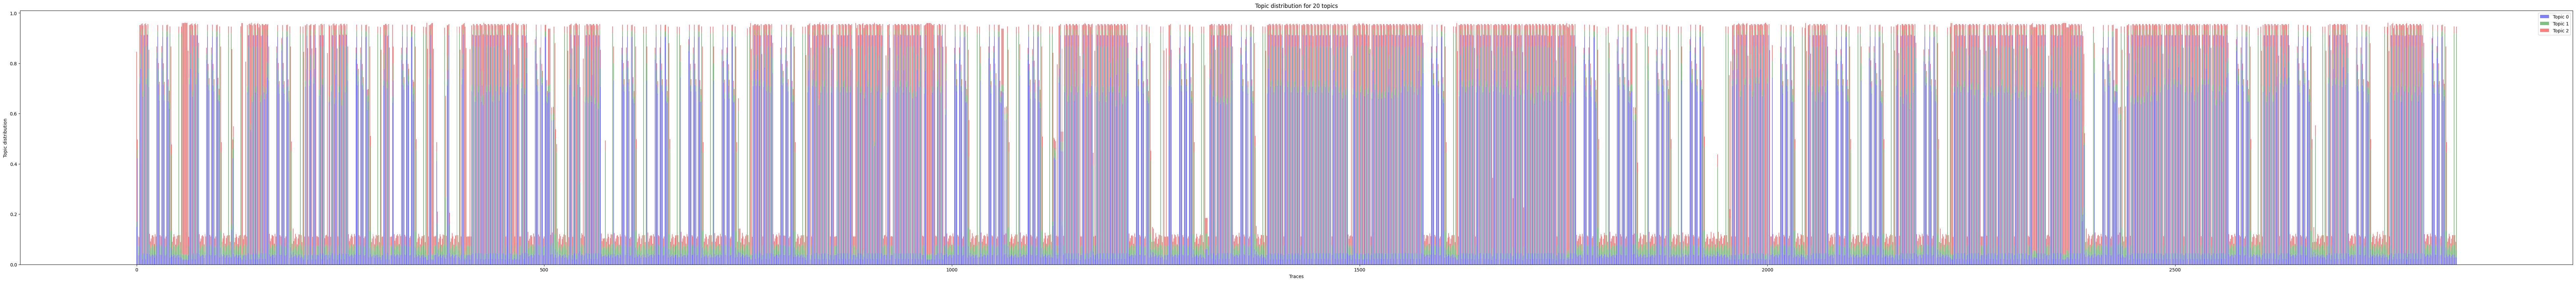

In [17]:
# Obtener los tópicos y las palabras más relevantes de cada tópico
top_words = 10
feature_names = tfidf.get_feature_names()
topics = []
for topic_idx, topic in enumerate(ldia.components_):
    topic_top_words = [feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]
    topics.append((topic_idx, topic_top_words))

# Mostrar los tópicos y las palabras más relevantes de cada tópico
for topic in topics:
    print(f'Topic {topic[0]}: {" ".join(topic[1])}')

# Obtener la distribución de tópicos para cada traza
topic_distribution = ldia.transform(df_ds)

# Graficar la distribución de tópicos para cada traza
plt.figure(figsize=(100,10 ))
plt.bar(np.arange(len(topic_distribution)), topic_distribution[:,0], color='b', alpha=0.5, label='Topic 0')
plt.bar(np.arange(len(topic_distribution)), topic_distribution[:,1], bottom=topic_distribution[:,0], color='g', alpha=0.5, label='Topic 1')
plt.bar(np.arange(len(topic_distribution)), topic_distribution[:,2], bottom=topic_distribution[:,:2].sum(axis=1), color='r', alpha=0.5, label='Topic 2')
#plt.bar(np.arange(len(topic_distribution)), topic_distribution[:,3], bottom=topic_distribution[:,:3].sum(axis=1), color='c', alpha=0.5, label='Topic 3')
#plt.bar(np.arange(len(topic_distribution)), topic_distribution[:,4], bottom=topic_distribution[:,:4].sum(axis=1), color='m', alpha=0.5, label='Topic 4')
plt.xlabel('Traces')
plt.ylabel('Topic distribution')
plt.title(f'Topic distribution for {num_topics} topics')
plt.legend()
plt.show()

### Topic List 🔒

In [43]:
num_topics=20 #og 7
topics=load_topic_list(num_topics=num_topics)
if not topics: 
    topics = []
    for trace in corpus_load['tokens']:
        trace_topics=[]
        for log in trace:
            log_vectorized = tfidf.transform([log])

            identifier= 'Pionier_medium_11052023_v1'
            model_name = f"LDA_{num_topics}_topics_{identifier}"
            model_path = os.path.join("LDA_models", f"{model_name}.pkl")
            with open(model_path, 'rb') as file:
                ldia = pickle.load(file)

            topic_idx = ldia.transform(log_vectorized)[0].argmax()
            trace_topics.append(topic_idx)
        topics.append(trace_topics)

    save_topic_list(topics,num_topics)
    topics=load_topic_list(num_topics=num_topics)

 Pickle file with 20 topics not found
TopicsPerLog/TPL_20_24112023_(0).pkl saved successfully
List with topics-per-log loaded from TopicsPerLog/TPL_20_24112023_(0).pkl


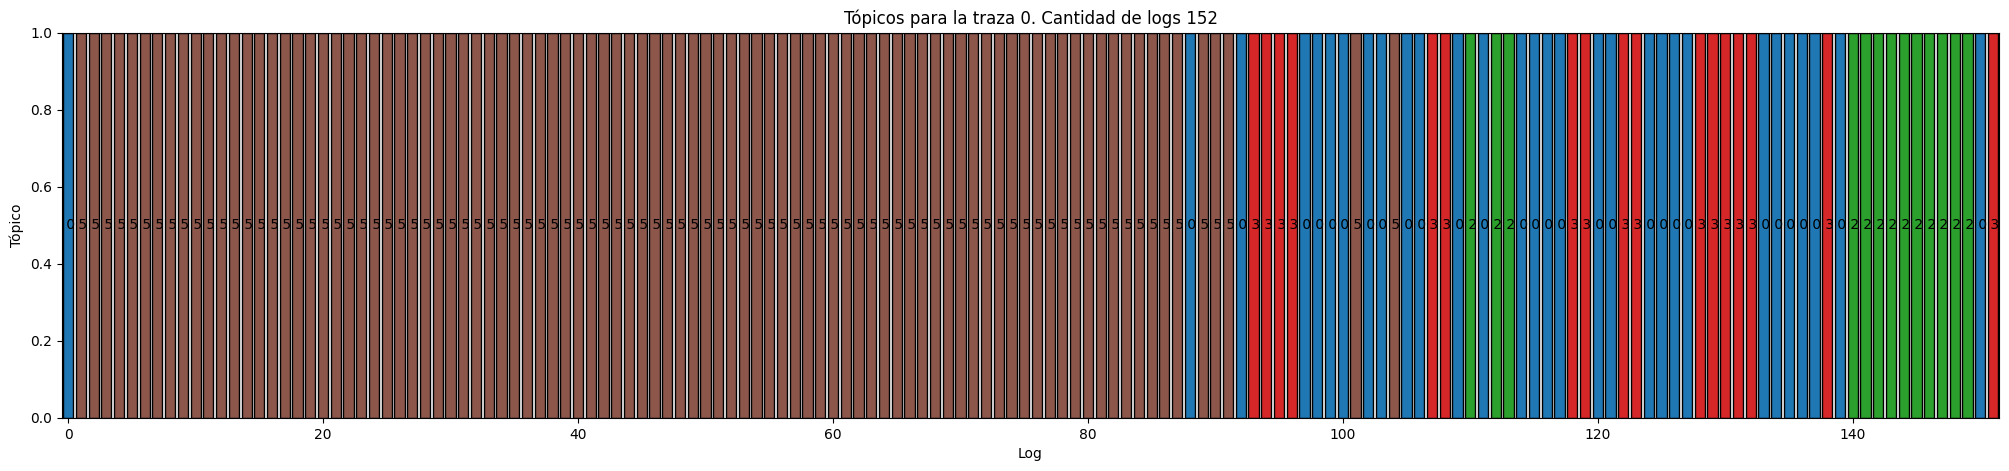

In [19]:
# Obtener los tópicos para una traza en específico
k=0
error_indexes=list(ds.index[ds.index['ERROR'] == True].index)
trace_index = error_indexes[k]
trace_logs = corpus_load.tokens.iloc[trace_index]
num_logs=len(corpus_load.tokens.iloc[trace_index])
trace_topics = topics[error_indexes[k]]

# Crear un gráfico de barras que muestre los tópicos de cada log
num_logs = len(trace_logs)
fig, ax = plt.subplots(figsize=(25, 5))
for i in range(num_logs):
    topic = trace_topics[i]
    log = trace_logs[i]
    color = f'C{topic}'
    ax.bar(i, 1, color=color, edgecolor='black')
    ax.text(i, 0.5,f' {topic}', ha='center', va='center',fontsize=10)
ax.set_xlim([-0.5, num_logs-0.5])
ax.set_ylim([0, 1])
ax.set_xlabel('Log')
ax.set_ylabel('Tópico')
ax.set_title(f'Tópicos para la traza {trace_index}. Cantidad de logs {num_logs}')
plt.show()

In [20]:
def graphic_pertrace(data=ds.index, corpus=corpus_load, trace= int, topics= int):
    
    #define traces with error and non error
    error_indexes=list(data[data['ERROR'] == True].index)
    if trace in error_indexes:
        trace_index = error_indexes[trace]
        #Error_label
        error_label='True'
    else:
        non_error_indexes=list(data[data['ERROR'] == False].index)
        trace_index=non_error_indexes[trace]
        error_label='False'

    #import the specific tokens for the trace given
    trace_logs = corpus.tokens.iloc[trace]

    #import the topics per log for the trace given
    topics_pertrace= load_topic_list(num_topics=topics)
    if not topics_pertrace:
        return None 

    trace_topics = topics_pertrace[trace]

    #graph settings:
    num_logs = len(trace_logs)
    fig, ax = plt.subplots(figsize=(25, 5))
    for i in range(num_logs):
        topic = trace_topics[i]
        log = trace_logs[i]
        color = f'C{topic}'
        ax.bar(i, 1, color=color, edgecolor='black')
        ax.text(i, 0.5,f' {topic}', ha='center', va='center',fontsize=10)
    ax.set_xlim([-0.5, num_logs-0.5])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Log')
    ax.set_ylabel('Tópico')
    ax.set_title(f'Tópicos para la traza {trace}. Cantidad de logs {num_logs}. ERROR: {error_label}, LDA {topics} topics')
    plt.show()


List with topics-per-log loaded from TopicsPerLog/TPL_7_27082023_(0).pkl


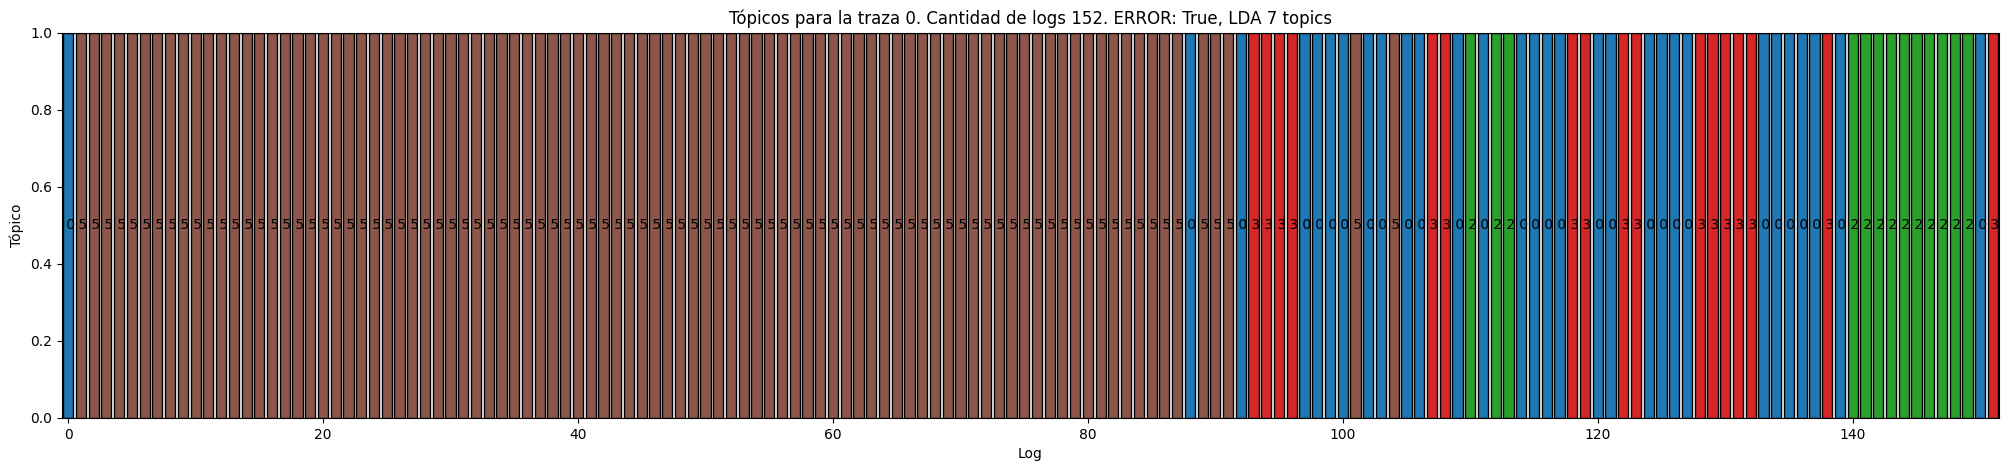

In [21]:
graphic_pertrace(trace=0, topics=7)

In [25]:
# Obtener los tópicos para una traza en específico

error_indexes=list(ds.index[ds.index['ERROR'] == True].index)

# Crear un gráfico de barras que muestre los tópicos de cada log
num_logs = len(trace_logs)
fig, ax = plt.subplots(len(error_indexes),1,figsize=(100, 20))
fig.set_size_inches(200,100)

for h in range(len(error_indexes)):

    trace_index = error_indexes[h]
    trace_logs = corpus_load.tokens.iloc[trace_index]
    num_logs=len(corpus_load.tokens.iloc[trace_index])
    trace_topics = topics[trace_index]
    
    for i in range(num_logs):
        topic = trace_topics[i]
        log = trace_logs[i]
        color = f'C{topic}'
        ax[h].bar(i, 2, color=color, edgecolor='black')
        ax[h].text(i, 0.5,f' {topic}', ha='center', va='center',fontsize=10)
        ax[h].set_xlim([-0.5, num_logs-0.5])
        ax[h].set_ylim([0, 1])
        #ax[h].set_xlabel('Log')
        ax[h].set_ylabel(f'Trace {trace_index} \n Total logs: {num_logs} ')
        #ax[h].set_title(f'Tópicos for trace {trace_index}')

plt.show()

In [23]:
import random 
no_error_indexes=random.sample( list(ds.index[ds.index['ERROR'] == False].index), 74)

# Crear un gráfico de barras que muestre los tópicos de cada log
fig, ax = plt.subplots(len(no_error_indexes),1,figsize=(100, 20))
fig.set_size_inches(200,100)

for h in range(len(no_error_indexes)):

    trace_index = no_error_indexes[h]
    trace_logs = corpus_load.tokens.iloc[trace_index]
    num_logs=len(corpus_load.tokens.iloc[trace_index])
    trace_topics = topics[trace_index]
    
    for i in range(num_logs):
        topic = trace_topics[i]
        log = trace_logs[i]
        color = f'C{topic}'
        ax[h].bar(i, 2, color=color, edgecolor='black')
        ax[h].text(i, 0.5,f' {topic}', ha='center', va='center',fontsize=10)
        ax[h].set_xlim([-0.5, num_logs-0.5])
        ax[h].set_ylim([0, 1])
        #ax[h].set_xlabel('Log')
        ax[h].set_ylabel(f'Trace {trace_index} \n Total logs: {num_logs} ')
        #ax[h].set_title(f'Tópicos for trace {trace_index}')

plt.show()

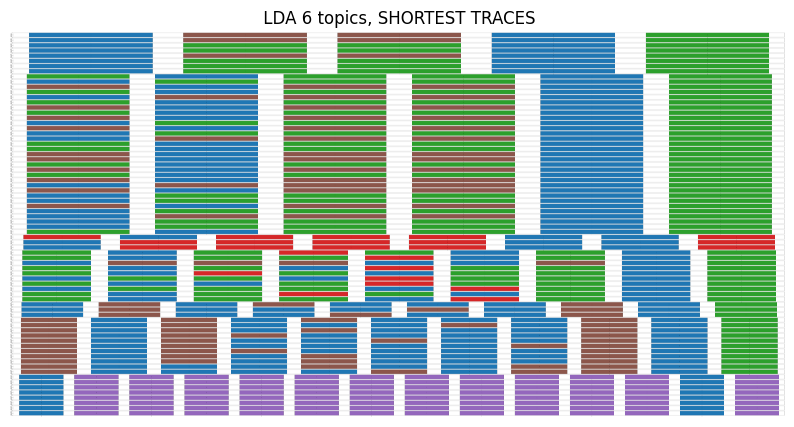

In [43]:
%run A2_painting_logs.py

##### Determining longest and shortest traces:

In [26]:
corpus=load_corpus( instrument='Pionier', size='medium') 
corpus

Loaded file: Corpus\Pionier_medium_11052023_v1.pkl


tokens
0     [Started_at_{}_(underlined), INS_MODE_=_'OBSERV-H', ISS_IAS_HMAG_=_'{}', SEQ_OPL_BEAM3_=_'{}', SEQ_OPL_BEAM4_=_'{}', INS_DISP_NAME_=_'GRISM', TEL_COU_ALPHA_=_'{}', ISS_BASELINE_=_'{}', TEL_COU_EPOCH_=_'{}', SEQ_DL_PRESET_=_'T', ISS_VLTITYPE_=_'snapshot', SEQ_OPL_BEAM1_=_'{}', SEQ_OPL_BEAM2_=_'{}', SEQ_PRESET_=_'T', SEQ_PUPIL_=_'F', TEL_COU_DELTA_=_'{}', AOS_AO_MODE_=_'FULL_AO', TEL_COU_PMA_=_'...
1     [Started_at_{}_(underlined), PIONIER_gen_tec_scan_--_Scanning_mode_setup:_Normal_(yellow), DET_DIT_=_'{}', DET_TRK_ST_=_'T', DET_GAIN_=_'HIGH', INS.LAMP2.STOP_Lamp_turned_off., INS.LAMP1.STOP_Lamp_turned_off., STATUS_-function_INS.MODE_(blue), Send_command_'STATUS'_',INS.MODE,FALSE'_to_sub-system_'ICS'_..., Reply_(not_last)_to_'STATUS'_received:_'INS.MODE_PARK'_(len='{}')(last_reply_will_be_ig...
2     [PIONIER_gen_tec_scan_--_Scanning_mode_setup:_Normal_(yellow), Started_at_{}_(underlined), DET_TRK_ST_=_'T', DET_DIT_=_'{}', DET_GAIN_=_'HIGH', STATUS_-function_INS.MODE_(blue), Send_command_'STATUS'_',INS.MODE,FALSE'_to_sub-system_'ICS'_..., Reply_(not_last)_to_'STATUS'_received:_'INS.MODE_PARK'_(len='{}')(last_reply_will_be_ignored), INS.MODE_{ARG}_(SpringGreen4), beginning_exposure_{}_of_{}...
3     [Started_at_{}_(underlined), PIONIER_gen_tec_scan_--_Scanning_mode_setup:_Normal_(yellow), DET_DIT_=_'{}', DET_GAIN_=_'HIGH', DET_TRK_ST_=_'T', STATUS_-function_INS.MODE_(blue), Send_command_'STATUS'_',INS.MODE,FALSE'_to_sub-system_'ICS'_..., Reply_(not_last)_to_'STATUS'_received:_'INS.MODE_OBSERV-H'_(len='{}')(last_reply_will_be_ignored), beginning_exposure_{}_of_{}_({})_..._(underlined), INS...
4     [Started_at_{}_(underlined), DPR_CATG_=_'CALIB', DPR_TECH_=_'INTERFEROMETRY', DPR_TYPE_=_'FRINGE,OBJECT', SEQ_NEXPO_=_'{}', SEQ_NSCANS_=_'{}', STATUS_-function_DET.READOUT.MODE_(blue), Send_command_'STATUS'_',DET.READOUT.MODE,FALSE'_to_sub-system_'DCS'_..., Last_Reply_to_'STATUS'_from_'DCS'_received:_'DET.READOUT.MODE_{ARG}'_(len='{}'), DET.READOUT.MODE_{ARG}_(SpringGreen4), STATUS_-function_D...
...                                                                                                                                                                                                                                                                                                                                                                                                               ...
2841  [PIONIER_gen_tec_setup_--_Instrument_setup_(FREE)_(yellow), Started_at_{}_(underlined), SEQ_WIN_SINGLE_=_'F', INS_MODE_=_'CALIB-H', INS_DISP_NAME_=_'FREE', STATUS_-function_INS.MODE_(blue), Reply_(not_last)_to_'STATUS'_received:_'INS.MODE_CALIB-H'_(len='{}')(last_reply_will_be_ignored), Send_command_'STATUS'_',INS.MODE,FALSE'_to_sub-system_'ICS'_..., INS.MODE_{ARG}_(SpringGreen4), beginning_ex...
2842  [Started_at_{}_(underlined), PIONIER_gen_tec_standby_--_Set_PIONIER_standby_in_day-time_(yellow), INS_WHAT_=_'DAY', INS.LAMP1.STOP_Lamp_turned_off., INS.LAMP2.STOP_Lamp_turned_off., Executing_ACCESS_VLTI,IGNORE_command_..., ##ACCESS_command_done, Executing_SETUP_command_..., {}_-_ic0fbInsModel.C:{}:_NOTICE:_Irrelevant_setup_key(s)_contained_in_SETUP_buffer:, {}_-_ic0fbInsModel.C:{}:_NOTICE:_Ir...
2843  [PIONIER_gen_tec_setup_--_Instrument_setup_(yellow), Started_at_{}_(underlined), INS_MODE_=_'OBSERV-H', INS_DISP_NAME_=_'FREE', SEQ_WIN_SINGLE_=_'F', STATUS_-function_INS.MODE_(blue), Send_command_'STATUS'_',INS.MODE,FALSE'_to_sub-system_'ICS'_..., Reply_(not_last)_to_'STATUS'_received:_'INS.MODE_PARK'_(len='{}')(last_reply_will_be_ignored), INS.MODE_{ARG}_(SpringGreen4), beginning_exposure_{}...
2844  [Started_at_{}_(underlined), DET_NDIT_=_'{}', SEQ_BEAM_LIST_=_'{}_{}_{}_{}', DET_DIT_=_'{}', DET_GAIN_=_'LOW', SEQ_FLUX_TIME_=_'{}', SEQ_GRID_STEP_=_'{}e-{}', SEQ_GRID_GEOM_=_'{}x20', SEQ_SAVE_=_'T', STATUS_-function_INS.MODE_(blue), Reply_(not_last)_to_'STATUS'_received:_'INS.MODE_OBSERV-H'_(len='{}')(last_reply_will_be_ignored), 

In [27]:
non_error_rows=list(ds.index[ds.index['ERROR'] == False].index)
save_length=[ len(corpus.iloc[row][0]) for row in non_error_rows  ]
save_length[:10]

[50, 49, 367, 291, 101, 368, 15, 101, 134, 369]

In [28]:
#indexed_lengths = list(enumerate(save_length)) 
indexed_lengths= list(zip(non_error_rows, save_length))
longest_indexed_lengths = sorted(indexed_lengths, key=lambda x: x[1], reverse=True)
shortest_indexed_lengths= sorted(indexed_lengths, key=lambda x: x[1], reverse=False)

In [29]:
shortest_indexed_lengths[:10]

[(15, 5),
 (569, 5),
 (1020, 5),
 (1069, 5),
 (1269, 5),
 (1792, 5),
 (1881, 5),
 (2435, 5),
 (42, 6),
 (103, 6)]

In [30]:
longest_traces=[longest_indexed_lengths[x][0] for x in range(74) ]

# Crear un gráfico de barras que muestre los tópicos de cada log
fig, ax = plt.subplots(len(longest_traces),1,figsize=(100, 20))
fig.set_size_inches(200,100)
topics_pertrace= load_topic_list(num_topics=num_topics)

for h in range(len(longest_traces)):

    trace_index = longest_traces[h]
    trace_logs = corpus_load.tokens.iloc[trace_index]
    num_logs=len(corpus_load.tokens.iloc[trace_index])
    trace_topics = topics_pertrace[trace_index]
    
    for i in range(num_logs):
        topic = trace_topics[i]
        log = trace_logs[i]
        color = f'C{topic}'
        ax[h].bar(i, 2, color=color, edgecolor='black')
        ax[h].text(i, 0.5,f' {topic}', ha='center', va='center',fontsize=10)
        ax[h].set_xlim([-0.5, num_logs-0.5])
        ax[h].set_ylim([0, 1])
        #ax[h].set_xlabel('Log')
        ax[h].set_ylabel(f'Trace {trace_index} \n Total logs: {num_logs} ')
        #ax[h].set_title(f'Tópicos for trace {trace_index}')

plt.show()

List with topics-per-log loaded from TopicsPerLog/TPL_7_27082023_(0).pkl


In [31]:
shortest_traces=[shortest_indexed_lengths[x][0] for x in range(74) ]

# Crear un gráfico de barras que muestre los tópicos de cada log
fig, ax = plt.subplots(len(shortest_traces),1,figsize=(100, 20))
fig.set_size_inches(200,100)
#topics_pertrace= load_topic_list(num_topics=10)

for h in range(len(shortest_traces)):

    trace_index = shortest_traces[h]
    trace_logs = corpus_load.tokens.iloc[trace_index]
    num_logs=len(corpus_load.tokens.iloc[trace_index])
    trace_topics = topics_pertrace[trace_index]
    
    for i in range(num_logs):
        topic = trace_topics[i]
        log = trace_logs[i]
        color = f'C{topic}'
        ax[h].bar(i, 2, color=color, edgecolor='black')
        ax[h].text(i, 0.5,f' {topic}', ha='center', va='center',fontsize=10)
        ax[h].set_xlim([-0.5, num_logs-0.5])
        ax[h].set_ylim([0, 1])
        #ax[h].set_xlabel('Log')
        ax[h].set_ylabel(f'Trace {trace_index} \n Total logs: {num_logs} ')
        #ax[h].set_title(f'Tópicos for trace {trace_index}')

plt.show() #:) :)

In [32]:
trace_index

1476